# Part 3 : Build Model using  XGBoost

Python Packages Used : 
1. data processing : numpy, pandas, regular expression(re)
2. data modeling   : sklearn, XGBoost

### Organization of the Notebook

Part 1: Load Packages 

Part 2: Read Data 

Part 3: Process Data 

Part 4: Build Model

1. Check Class Labels & Label Weights

2. Split Data : Train (80%) and Test (20%) 

3. Build Model using Default Parameters 

4. Apply Model on the Test Data

5. Model Performnace on the Test Data

6. Feature Importance 

## Part 1: Load Packages

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.model_selection import train_test_split
import shap

In [4]:
%matplotlib inline

## Part 2: Read Data

In [5]:
df = pd.read_excel("data_customerSatisfaction.xlsx", engine="openpyxl")

In [6]:
print("Shape of the Dataframe :", df.shape)

Shape of the Dataframe : (129880, 24)


## Part 3: Process Data

In [7]:
print( df.columns.to_list() )

['id', 'SatisfactionType', 'Gender', 'CustomerType', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [8]:
"""Fix Column Names : Remove White Spaces & Slashes"""
oldName = df.columns.to_list()
newName = [re.sub(" ", "_", x.title()) for x in oldName]
colName = {oldName[i]: newName[i] for i in range(len(oldName))} 
df = df.rename(columns=colName)
df = df.rename(columns={"Departure/Arrival_Time_Convenient":"Departure_Arrival_Time_Convenient"})

In [9]:
#print( df.dtypes )

#### Drop Column "id"

Unique integer. It does not have any leverage in the modeling compared to other features.

In [10]:
df = df.drop(["Id"], axis=1)  

#### Replace Age Null Values by Median Age

In [11]:
medianAge = df.loc[df['Age'].isnull()==False, 'Age'].median()
df.loc[df['Age'].isnull()==True, 'Age'] = medianAge

#### Leg Room Service has Catagores like 0,1,2,3,4,5,44,55. Change 44,55 to 0 

In [12]:
"""Fix Leg Room Service"""
df.loc[ df["Leg_Room_Service"] > 5, "Leg_Room_Service"] = 0

#### Replace Food and Drink Null Values by 1

Find the subset of data having "Online Boarding=Null"

Explore the data property on all other categorical columns in this subset

Assign category to "Online Boarding=Null" based on the observed property of the subset 

In [13]:
"""Fix Food and Drink"""
#df[ df["Food and drink"].isnull()==True ]   # DisLoyal but Satisfied
df.loc[ df["Food_And_Drink"].isnull()==True, "Food_And_Drink" ] = 1.0

#### Replace Online Boarding Null Values  by 1

Following the procedure in "Food and Drink"

In [14]:
"""Fix Online Boarding"""
# df[ df["Online boarding"].isnull()==True ] # Loyal and Satisfied
df.loc[ df["Online_Boarding"].isnull()==True, "Online_Boarding" ] = 1.0

#### Maximum Flight Distance is 9999999. Replace it by Column Median

Flight Distance has outliers

Replace outliers by the column mdedian. Median itself is insensitive to outliers in the data.

In [15]:
"""Flight Distance"""
# print( df["Flight Distance"].mean() ) 
# print( df["Flight Distance"].max() )
distList = sorted( df["Flight_Distance"].unique(), reverse= True)
df.loc[ df["Flight_Distance"] > distList[1],  "Flight_Distance"] = df["Flight_Distance"].median()
# print( df["Flight Distance"].mean() ) 
# print( df["Flight Distance"].max() )

#### Replace Baggage Handling Null values by 0

In [16]:
df.loc[ df["Baggage_Handling"].isnull() == True, "Baggage_Handling" ] = 0

#### Departure Delay in Minutes and Arrival Delay in Minutes are Strongly Correlated (r ~ 0.99) 

In [17]:
"""Drop Arrival Delay in Minutes instead of Departure Delay in Minutes"""
df = df.drop(["Arrival_Delay_In_Minutes"], axis=1)  

#### Make the Dataframe with Appropriate Data Types 

Feature with Float Data Type

In [18]:
df_float = df[['Age','Flight_Distance','Departure_Delay_In_Minutes']].copy()
df_float = df_float.astype('float64')
nFloat = df_float.shape[1]

In [19]:
df_feature = df.dtypes.to_frame().reset_index().rename(columns={"index": "Feature", 0: 'FeatureType'})
theObjects = df_feature[ df_feature['FeatureType'] == 'object']
df_object  = df[ theObjects['Feature'] ].copy() 

Feature with Interger Data Type

In [20]:
object_float_list = df_object.columns.to_list() + df_float.columns.to_list() 
colList = set( df.columns.to_list() )
ofList  = set( object_float_list )
colList.difference_update( ofList )
df_int = df[ list(colList) ].copy()
df_int = df_int.astype('int64')
df_str = df_int.astype('str')

In [21]:
df_object

,Satisfactiontype,Gender,Customertype,Type_Of_Travel,Class
0,satisfied,Male,disloyal Customer,Personal Travel,Eco
1,satisfied,Male,disloyal Customer,Personal Travel,Eco
2,satisfied,Male,disloyal Customer,Personal Travel,Eco
3,satisfied,Female,disloyal Customer,Personal Travel,Eco
4,satisfied,Male,disloyal Customer,Personal Travel,Eco
...,...,...,...,...,...
129875,satisfied,Female,Loyal Customer,Business travel,Business
129876,satisfied,Female,Loyal Customer,Business travel,Eco
129877,satisfied,Male,Loyal Customer,Business travel,Business
129878,satisfied,Female,Loyal Customer,Business travel,Business


#### Convert Categorical to Integer Type 

`Define Response Variable`

0 = "satisfied"
1 = "neutral or dissatisfied"

In [22]:
df_object['Y'] = df_object.apply(lambda row: 0 if row.Satisfactiontype=="satisfied" else 1, axis=1)

In [23]:
# df_object['Gender'] = df_object.apply(lambda row: 0 if row.Gender=="Female" else 1, axis=1)
# df_object['Customer_Type'] = df_object.apply(lambda row: 0 if row.Customer_Type=="disloyal Customer" else 1, axis=1)
# df_object['Type_Of_Travel'] = df_object.apply(lambda row: 0 if row.Type_Of_Travel=="Business travel" else 1, axis=1)
# df_object['Class'] = df_object.apply(lambda row: 0 if row.Class=="Business" else 1 if row.Class=="Eco" else 2, axis=1)

In [24]:
"""Dropping Satisfaction_V2. It is replaced by feature Y"""
df_object = df_object.drop(['Satisfactiontype'], axis=1)

Dummy Coding 

In [25]:
df_cat = pd.concat([df_object, df_str], axis=1)
df_dum = pd.get_dummies(df_cat)

Concate the Splitted Parts Back

In [26]:
"""Final Dataframe"""
df = pd.concat([df_dum, df_float], axis=1)
print(f'Shape of the final dataframe : {df.shape}')

Shape of the final dataframe : (129880, 97)


## Part 4: Build Model 

Label values extraction

In [27]:
y = df.Y
X = df.drop('Y', axis=1)

Looking for Label Balance in the Dataset

0 = "satisfied" (postive class)

1 = "neutral or dissatisfied" (negative class)

In [28]:
print(f'Class Labels: {set(y)}')
print(f'Zero Count = {len(y) - sum(y)}, One Count = {sum(y)}')
zero_frac = (len(y)-sum(y))/len(y)
one_frac  =  sum(y)/len(y)
print(f'Class distributions : {round(zero_frac,4), round(one_frac,4)}')

Class Labels: {0, 1}
Zero Count = 56428, One Count = 73452
Class distributions : (0.4345, 0.5655)


Data Split Train (80) - Test (20)

In [29]:
theSeed = 213
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'test data : {X_test.shape}')

train data: (90916, 96)
test data : (38964, 96)


#### Build Model 

Using Default Hyper-Parameters

In [30]:
model = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="auc"
)
xgb = model.fit(X_train, y_train)

#### Prediction

In [31]:
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [32]:
y_pred = model.predict_proba(X_test)[:,1]
print('The AUC of the XGB Model:', round( roc_auc_score(y_test,y_pred),5) )

The AUC of the XGB Model: 0.99497


In [33]:
accuracy = accuracy_score(y_test, predictions)
print(f"The Accuracy of the XGB Model : {round(accuracy, 4)}")

The Accuracy of the XGB Model : 0.9648


#### Feature Importance 

In [34]:
feature_important = xgb.get_booster().get_score(importance_type='weight')

key = list(feature_important.keys())
val = list(feature_important.values())

df_imp = pd.DataFrame(data=val, index=key, columns=["score"])
df_imp = df_imp.sort_values(by = "score", ascending=False).reset_index().rename(columns={'index':'feature'})

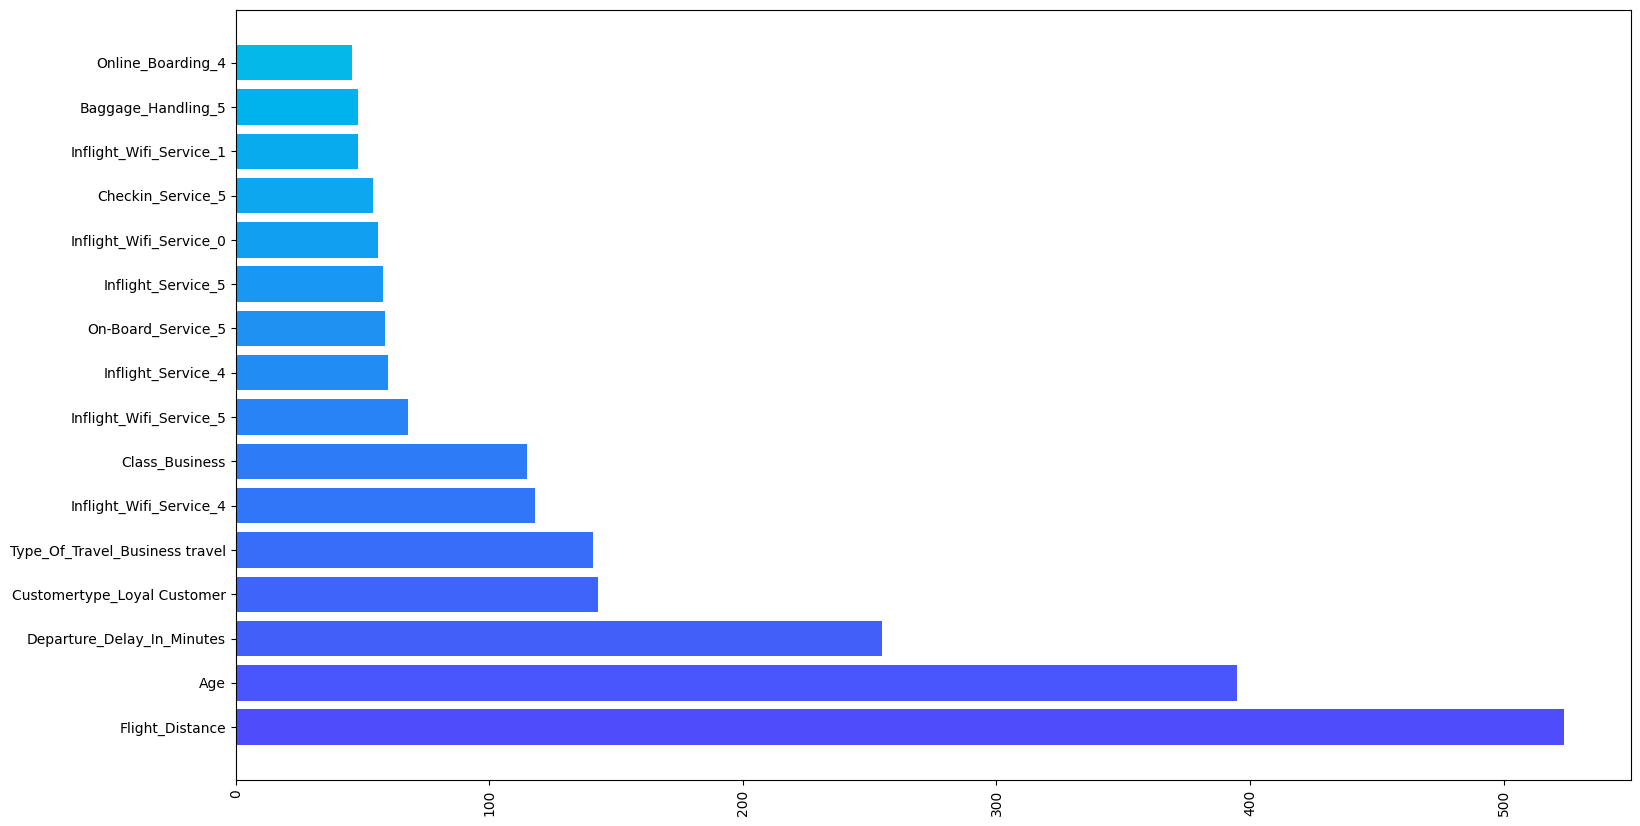

In [35]:
fig = plt.subplots( figsize=(18,10) )

colors = plt.cm.rainbow( np.linspace(0.1, 1.0, len(val))  )


plt.barh(df_imp.loc[0:15,'feature'], df_imp.loc[0:15,'score'], color=colors)
plt.xticks(rotation=90)
plt.show()